## Set Up and Load Data

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import tensorflow_decision_forests as tfdf
tfdf.keras.get_all_models()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

pd.set_option('display.max_columns', 15)

In [159]:
df = pd.read_csv('dataset/train.csv', index_col='PassengerId')
# df.drop(['Name'], axis=1, inplace=True)

## EDA

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


In [161]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [162]:
# Split PassengerId into group and number
df['Group'] = df.index.str[:4]
df['passenger_number'] = df.index.str[-2:]

In [163]:
# Split cabin structure
df['Cabin'].fillna('Z/9999/Z')
df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)
df.drop('Cabin', axis=1,inplace=True)
df[df['Deck'] == 'Z'] = np.nan
df[df['Side'] == 'Z'] = np.nan
df[df['Cabin_num'] == '9999'] = np.nan


In [164]:
# Select columns based on characteristics and dtypes

bool_cols = ['Transported','VIP']
df[bool_cols] = df[bool_cols].astype(bool)

category_cols = ['HomePlanet',
 'Destination',
 'Group',
 'passenger_number',
 'Deck',
 'Side']

spending_cols = ['RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

df[spending_cols] = df[spending_cols].fillna('0')

df[spending_cols] = df[spending_cols].astype('int64')

for col in category_cols:
    print(f'Unique values of {col}: {df[col].unique()}')
print('\n')
print(f'Boolean columns: {bool_cols}\nCategory columns: {category_cols}\nSpending columns:{spending_cols}')

Unique values of HomePlanet: ['Europa' 'Earth' 'Mars' nan]
Unique values of Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Unique values of Group: ['0001' '0002' '0003' ... '9278' '9279' '9280']
Unique values of passenger_number: ['01' '02' '03' '04' '05' '06' '07' '08']
Unique values of Deck: ['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']
Unique values of Side: ['P' 'S' nan]


Boolean columns: ['Transported', 'VIP']
Category columns: ['HomePlanet', 'Destination', 'Group', 'passenger_number', 'Deck', 'Side']
Spending columns:['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [165]:
# Sum of spending
df['Spending'] = df[spending_cols].sum(axis=1)
df.loc[:,['Spending']+spending_cols]

,Spending,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
PassengerId,,,,,,
0001_01,0,0,0,0,0,0
0002_01,736,109,9,25,549,44
0003_01,10383,43,3576,0,6715,49
0003_02,5176,0,1283,371,3329,193
0004_01,1091,303,70,151,565,2
...,...,...,...,...,...,...
9276_01,8536,0,6819,0,1643,74
9278_01,0,0,0,0,0,0
9279_01,1873,0,0,1872,1,0


In [166]:
# Surname column
df['Surname'] = df['Name'].str.split(expand=True)[1]

Text(0.5, 1.0, 'Distribution of Total Spending on CryoSleep')

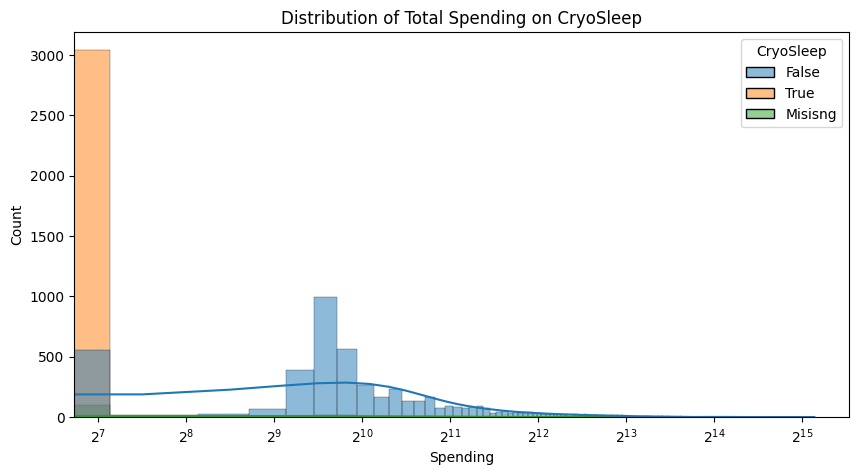

In [167]:
sample = df.copy()
sample['CryoSleep'].fillna('Misisng', inplace=True)
plt.figure(figsize=(10,5))
sns.histplot(data = sample, x = 'Spending', hue='CryoSleep', kde=True)
plt.xscale('log', base = 2)
plt.title('Distribution of Total Spending on CryoSleep')

Above graph shows that people with CryoSleep = True is likely to have Total Spending = 0. We can clean CryoSleep based on this feature and the rest can be filled with mean or median or 25th/75th percentile.

In [168]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

HomePlanet     201
CryoSleep      217
Destination    182
Age            179
Name           200
Deck           199
Cabin_num      199
Side           199
Surname        200
dtype: int64

In [169]:
columns_with_missing = missing_values[missing_values > 0].index.tolist()
columns_with_missing

['HomePlanet',
 'CryoSleep',
 'Destination',
 'Age',
 'Name',
 'Deck',
 'Cabin_num',
 'Side',
 'Surname']

In [170]:
df['CryoSleep'].unique()

array([False, True, nan], dtype=object)

In [171]:
df['CryoSleep'].value_counts()

CryoSleep
False    5439
True     3037
Name: count, dtype: int64

In [172]:
home_transported = df[['HomePlanet','Transported']].copy()
home_transported['HomePlanet'].fillna('Missing', inplace=True)
home_transported = pd.DataFrame(home_transported.groupby(['HomePlanet','Transported']).size()).reset_index()
home_transported.columns = ['HomePlanet','Transported','Count']
for i in home_transported.HomePlanet.unique().tolist():
    for j in home_transported.Transported.unique().tolist():
        count = home_transported[(home_transported['HomePlanet'] == i) & (home_transported['Transported'] == j)]['Count']
        home_transported.loc[(home_transported['HomePlanet'] == i) & (home_transported['Transported'] == j), 'percentage'] = round(count/(home_transported.groupby('HomePlanet')['Count'].sum()[i])*100,2)

Text(0.5, 1.0, 'Distribution of Missing Values')

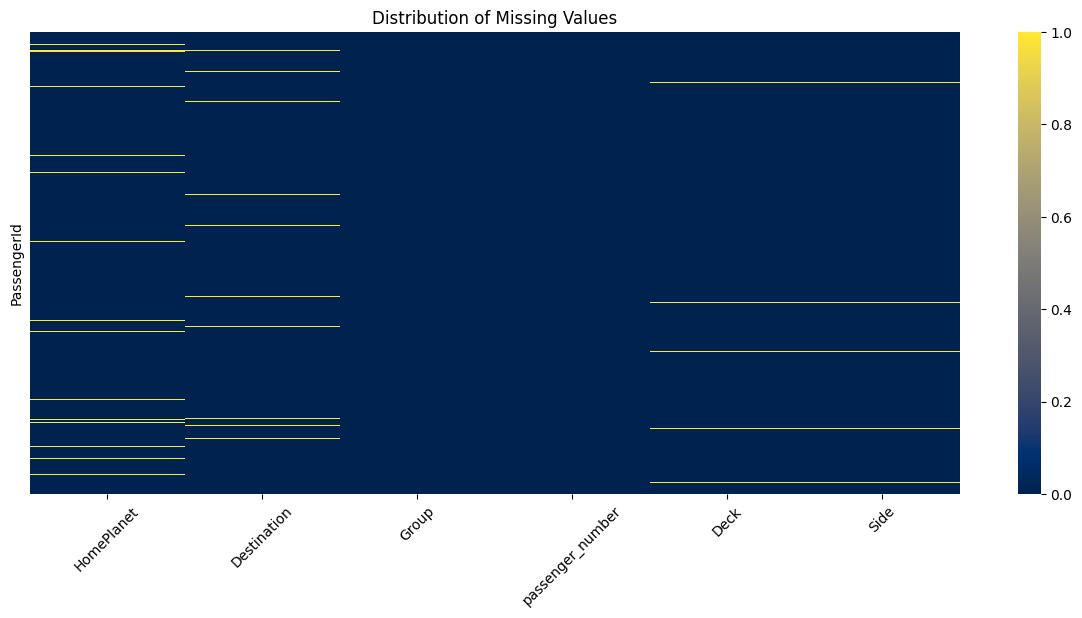

In [173]:
# Show the rate of missing values in every column

plt.figure(figsize=(15,6))
ax = sns.heatmap(data=df[category_cols].isnull(), cbar=True, cmap='cividis', yticklabels=False)
plt.xticks(rotation=45)
plt.title('Distribution of Missing Values')

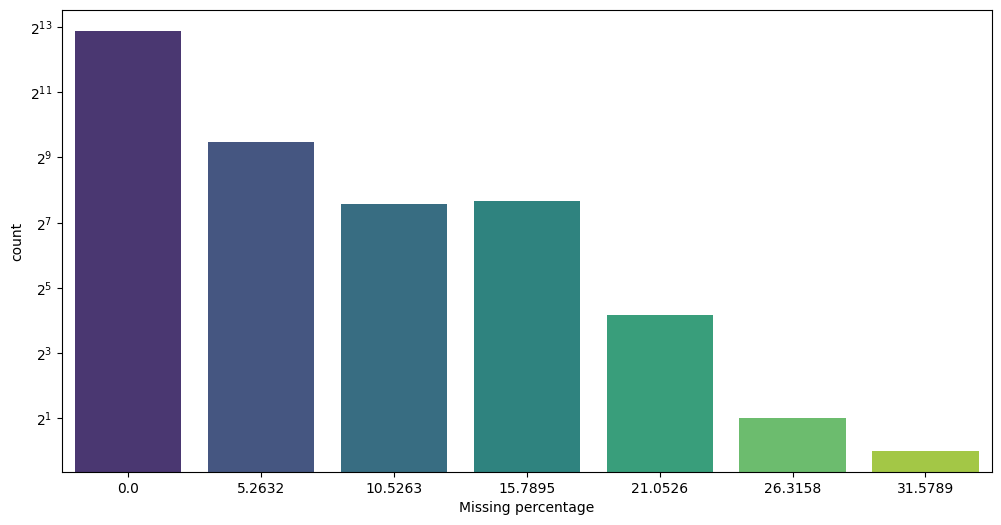

In [174]:
row_missing_percentage = round(df.isnull().mean(axis=1) * 100,4)
row_missing_df = pd.DataFrame({'PassengerId': df.index, 'Missing percentage': row_missing_percentage})

plt.figure(figsize=(12,6))
sns.countplot(data=row_missing_df, x='Missing percentage', palette='viridis')
plt.yscale('log', base = 2)

Around a thousand passengers don't have at least 1 missing value accross columns. Therefore, it would be better to not drop any rows and try to fill missing values for every column.

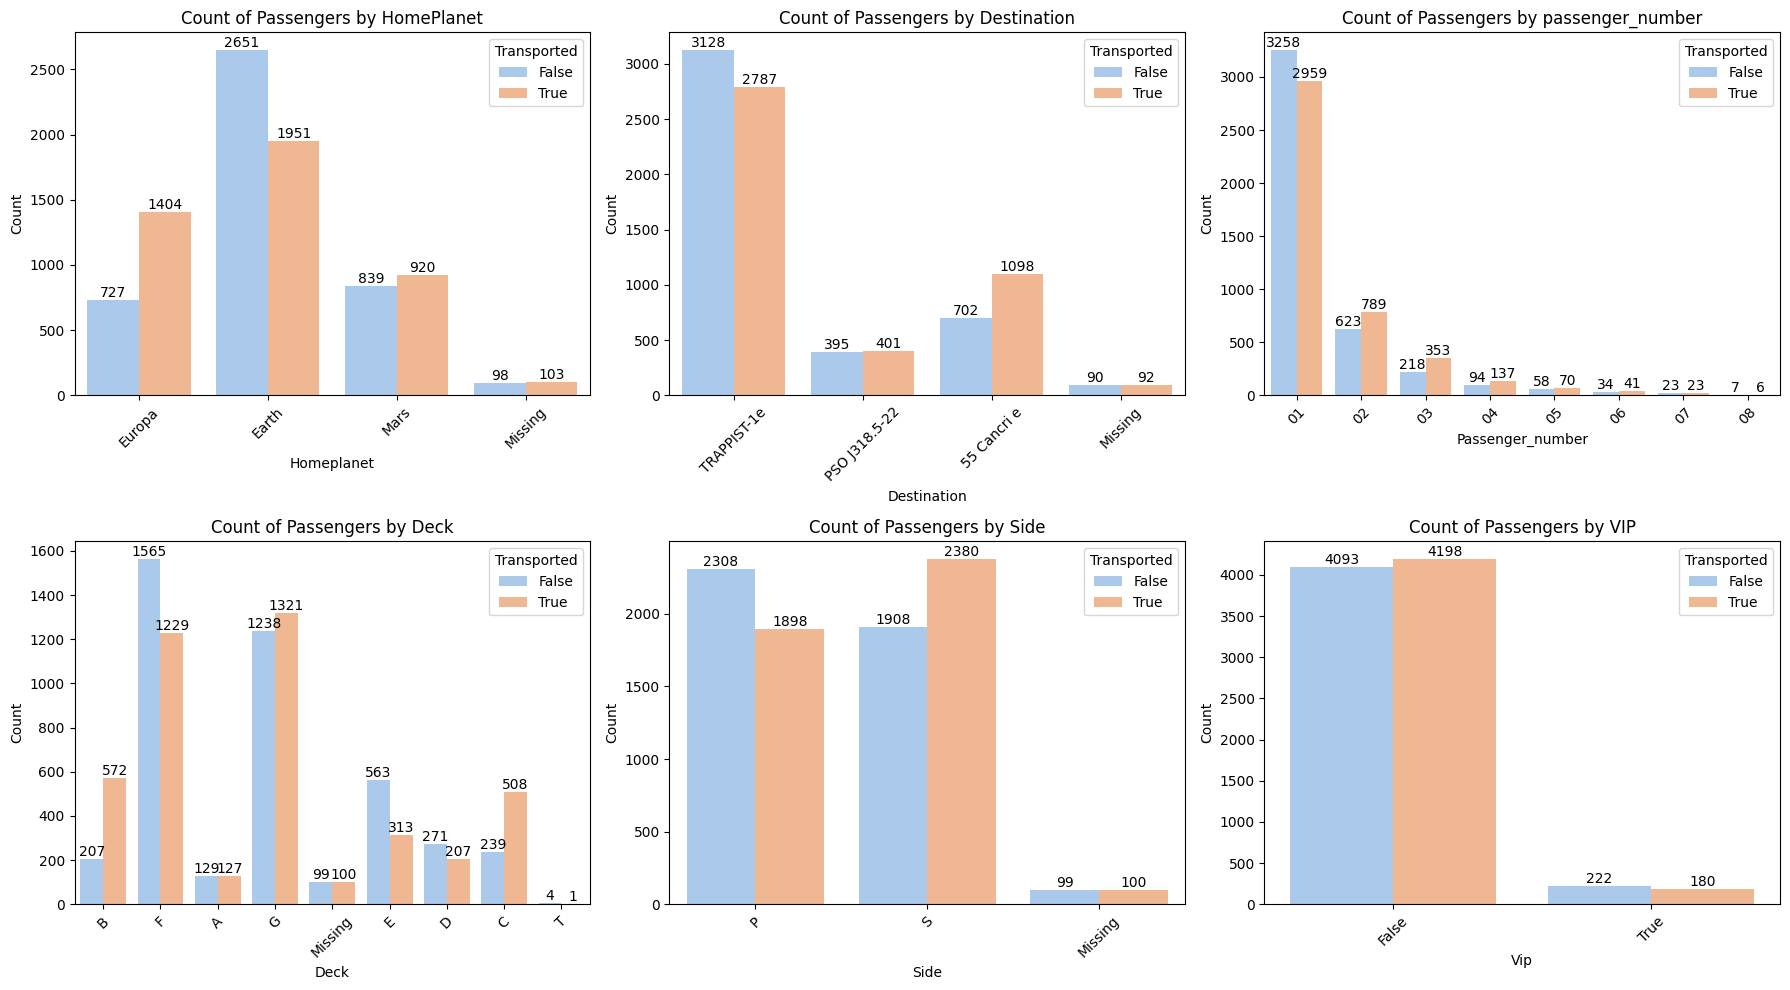

In [175]:
# Show the count of passengers by Category Columns

selected_col = [col for col in category_cols if col != 'Group']
selected_col.append('VIP')
sample_df = df.copy()
sample_df.fillna('Missing', inplace=True)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
ax = ax.ravel()
for i, col in enumerate(selected_col):
    sns.countplot(x=col, data=sample_df,hue = 'Transported', palette='pastel', ax=ax[i])
    for container in ax[i].containers:
        ax[i].bar_label(container, color='black', size=10)
    ax[i].set_title(f'Count of Passengers by {col}')
    ax[i].set_xlabel(col.capitalize())
    ax[i].set_ylabel('Count')
    ax[i].tick_params(axis='x', rotation = 45)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation between Spending Activities')

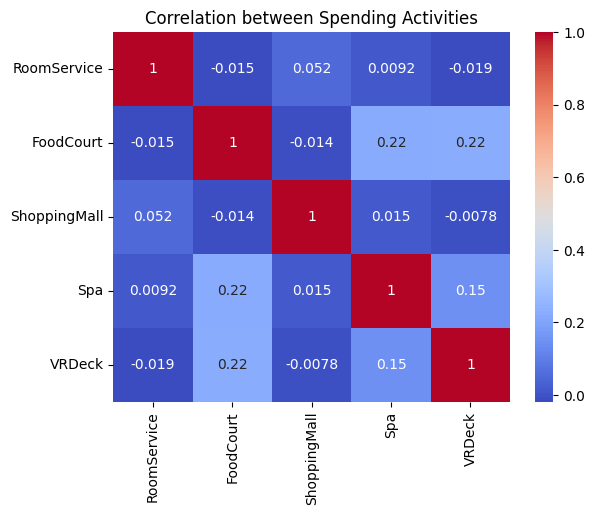

In [176]:
# Correlation Matrix of Numerical columns
spending_corr = df[spending_cols].corr()
sns.heatmap(spending_corr, annot=True, cmap='coolwarm')
plt.title("Correlation between Spending Activities")

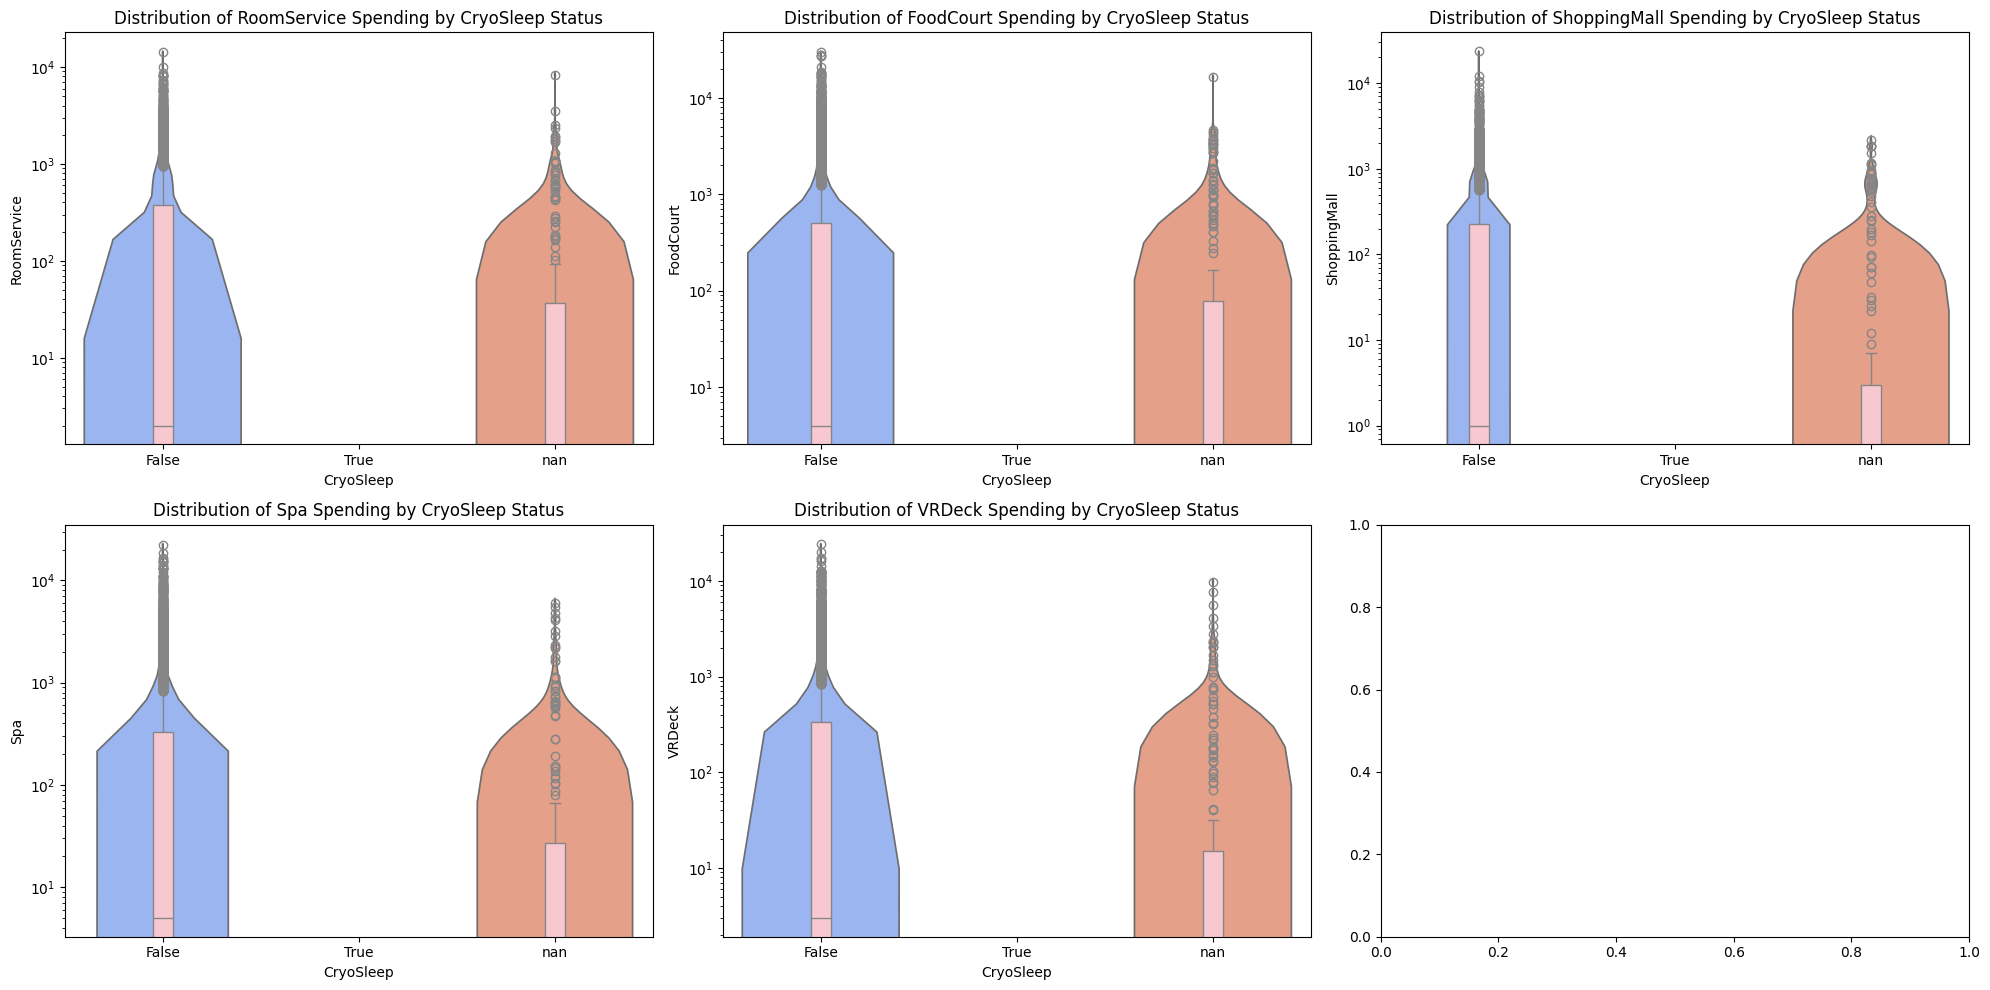

In [177]:
# Distribution of Amenities with CryoSleep status

sample_df = df[spending_cols + ['CryoSleep']].copy()
sample_df['CryoSleep'] = sample_df['CryoSleep'].astype(str)
sample_df['CryoSleep'].fillna('Missing', inplace=True)
sample_df.loc[:, spending_cols] = sample_df[spending_cols].fillna(0)

fig,ax = plt.subplots(nrows=2, ncols = 3, figsize = (20,10))
ax = ax.flatten()

for i, col in enumerate(spending_cols):
    sns.violinplot(x='CryoSleep', y=col, data=sample_df, inner=None, palette='coolwarm', ax=ax[i], color='lightblue')
    sns.boxplot(x='CryoSleep', y = col, data=sample_df, whis=1.5, width=0.1,ax=ax[i], color='pink')
    ax[i].set_yscale('log')
    ax[i].set_title(f'Distribution of {col} Spending by CryoSleep Status')
    ax[i].set_xlabel('CryoSleep')
    ax[i].set_ylabel(f'{col}')
plt.tight_layout()
plt.show()

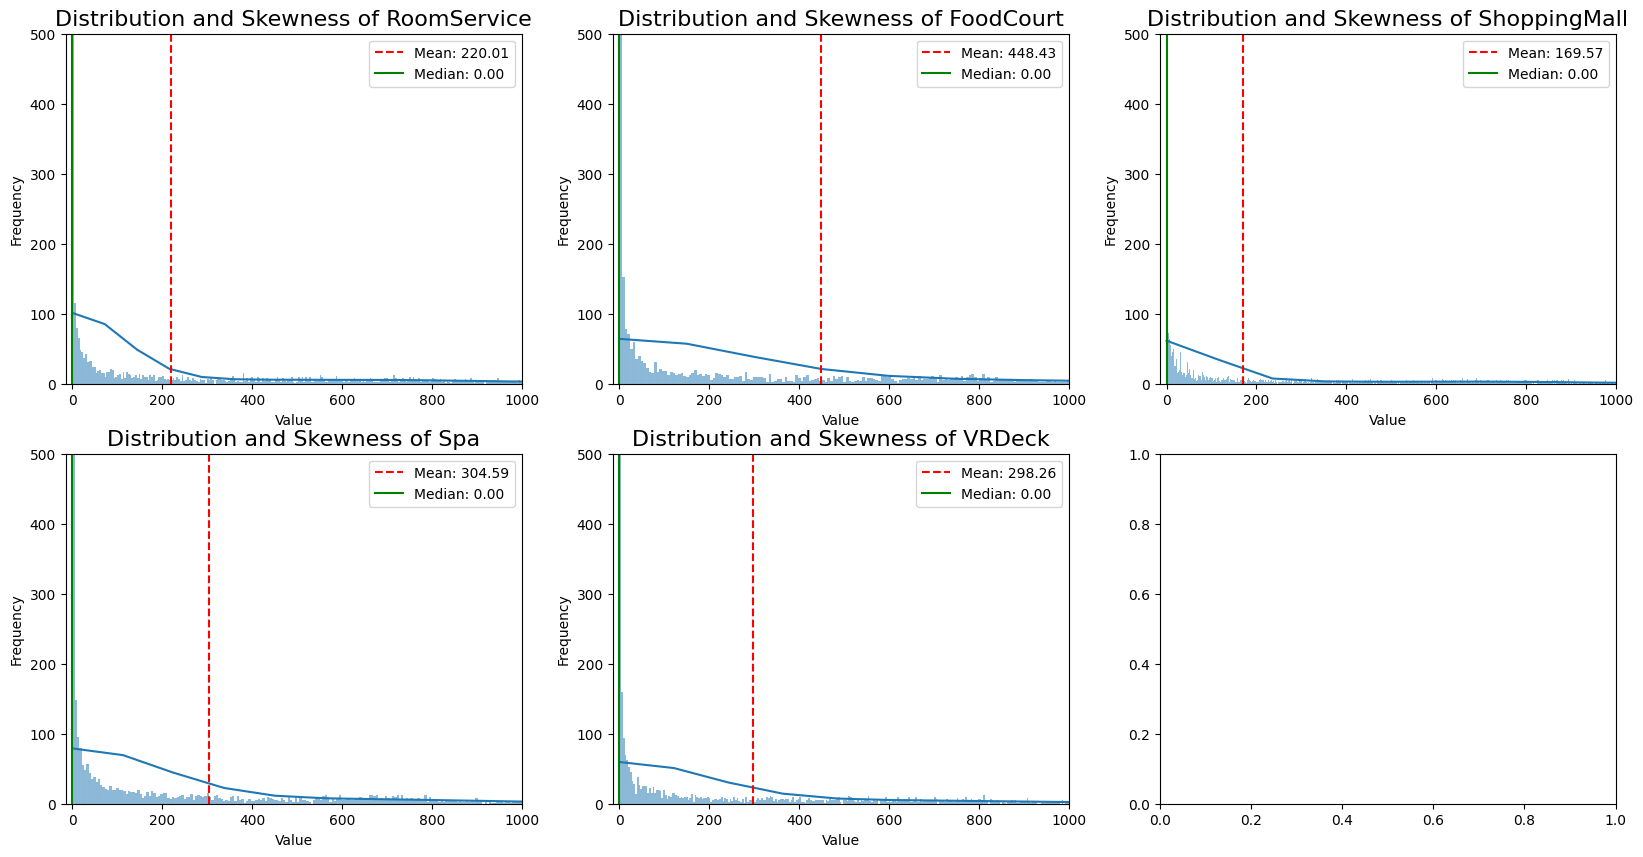

In [178]:
fig, ax = plt.subplots(2,3,figsize=(20, 10))
ax = ax.flatten()

amenities_cols = [col for col in spending_cols if col != 'VIP']
for i, col in enumerate(amenities_cols):
    sns.histplot(sample_df[col], kde=True, ax=ax[i])
    
    mean = sample_df[col].mean()
    ax[i].axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
    
    median = sample_df[col].median()
    ax[i].axvline(median, color='g', linestyle='-', label=f'Median: {median:.2f}')
    
    ax[i].set_title(f'Distribution and Skewness of {col}', fontsize=16)
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlim(-15,1000)
    ax[i].set_ylim(0,500)
    ax[i].legend()
plt.show()

Text(0.5, 1.0, 'Age Distribution')

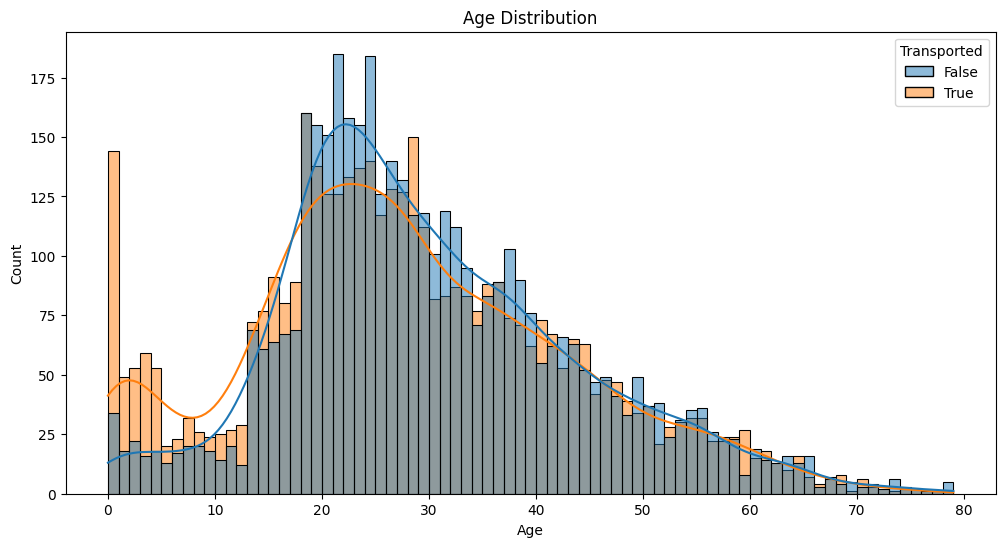

In [179]:
# Age distribution
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='Age', kde=True, hue='Transported', binwidth=1)
plt.title('Age Distribution')

Above graph shows that people around the age 20-30 seems to be transported more. It should be useful to categorize the age into group categories.

Text(0.5, 1.0, 'Count of Transported by Group Status')

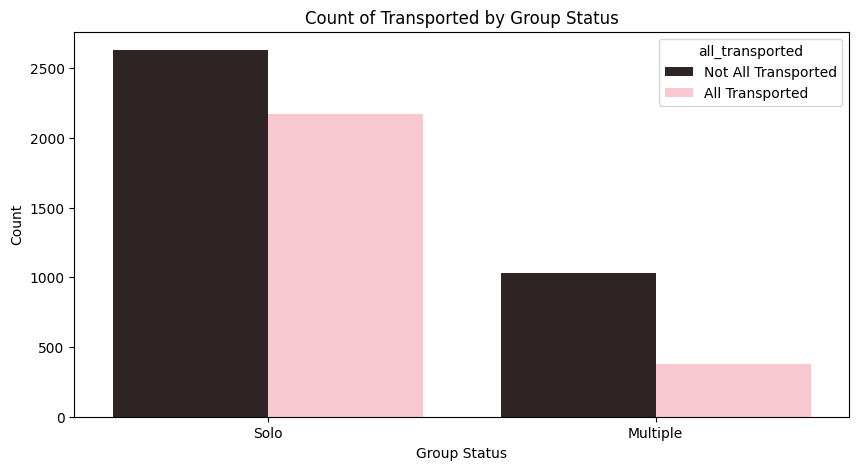

In [180]:
group_status = df.groupby('Group')['Transported'].all().reset_index()
group_status['all_transported'] = group_status['Transported'].map({True:'All Transported', False:'Not All Transported'})

group_counts = pd.DataFrame(df.groupby('Group')['passenger_number'].count())
group_counts['Solo'] = group_counts['passenger_number'].apply(lambda x: 'Solo' if x == 1 else 'Multiple')
group_counts.columns = ['number_of_ppl','Solo']
group_counts.reset_index(inplace=True)
combined_df = pd.concat([group_counts,group_status], axis=1)

plt.figure(figsize=(10,5))
sns.countplot(data=combined_df, x='Solo', hue='all_transported', color='pink')
plt.xlabel('Group Status')
plt.ylabel('Count')
plt.title('Count of Transported by Group Status')

Not everyone in the same group would be transported to the new planet.

Text(0.5, 1.0, 'Count of Groups having People From Same Planet')

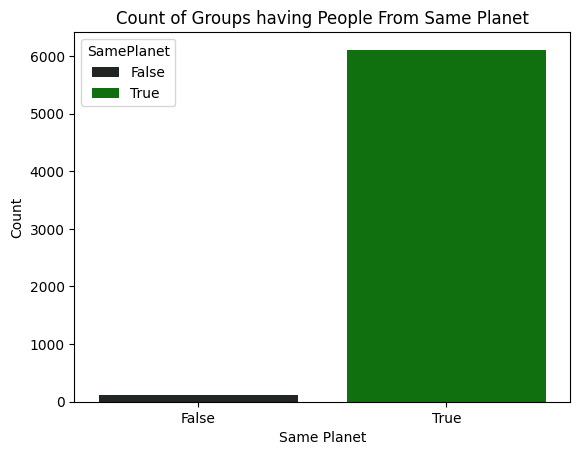

In [181]:
planet_check = df.groupby('Group')['HomePlanet'].nunique().reset_index()
planet_check['SamePlanet'] = planet_check['HomePlanet'] == 1
sns.countplot(data=planet_check, x='SamePlanet', hue='SamePlanet', color='green')
plt.xlabel('Same Planet')
plt.ylabel('Count')
plt.title('Count of Groups having People From Same Planet')

In [182]:
lst = list(planet_check.loc[planet_check['SamePlanet'] == False,'Group'])
lst = list(planet_check.loc[planet_check['SamePlanet'] == False,'Group'])
sample_df = df.loc[df['Group'].isin(lst),]
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, 0210_01 to 9274_01
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HomePlanet        0 non-null      object 
 1   CryoSleep         109 non-null    object 
 2   Destination       108 non-null    object 
 3   Age               111 non-null    float64
 4   VIP               111 non-null    bool   
 5   RoomService       111 non-null    int64  
 6   FoodCourt         111 non-null    int64  
 7   ShoppingMall      111 non-null    int64  
 8   Spa               111 non-null    int64  
 9   VRDeck            111 non-null    int64  
 10  Name              106 non-null    object 
 11  Transported       111 non-null    bool   
 12  Group             111 non-null    object 
 13  passenger_number  111 non-null    object 
 14  Deck              107 non-null    object 
 15  Cabin_num         107 non-null    object 
 16  Side              107 non-null    objec

Above sample_df.info() shows that those group having SamePlanet = False don't have HomePlanet yet. Other than that, every other group has people from Same Planet

## Feature Engineering

Since the age is highly right-skewed distribution, grouping age categories by using quantile seems to be a good approach.

In [186]:
df['Age'].fillna(df['Age'].mean(), inplace = True)

<Axes: xlabel='AgeCategory', ylabel='count'>

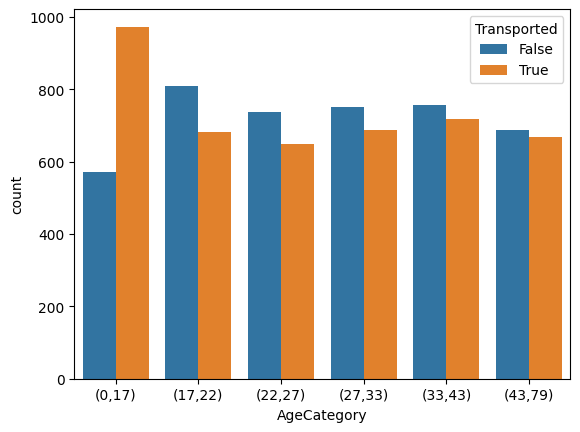

In [187]:
# Age categories
bins, bin_edges = pd.qcut(df['Age'], q=6, retbins=True)
bin_edges = [f'({bin_edges[i]:.0f},{bin_edges[i+1]:.0f})' for i in range(len(bin_edges)-1)]
df['AgeCategory'] = bins
df['AgeCategory'] = df['AgeCategory'].cat.rename_categories(bin_edges)
sns.countplot(data=df, x='AgeCategory', hue='Transported')

<Axes: xlabel='GroupSize', ylabel='count'>

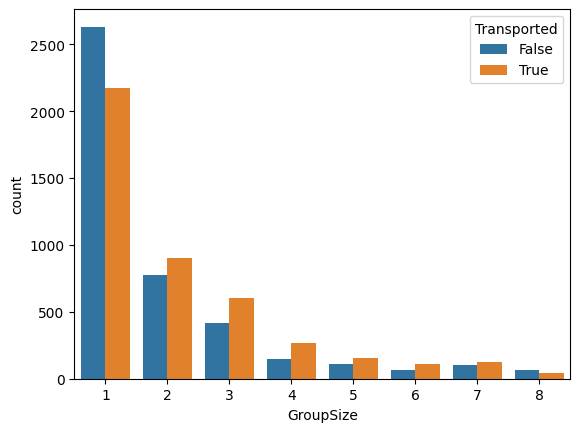

In [188]:
# Group Size
df['GroupSize'] = df.groupby('Group')['Group'].transform('count')
sns.countplot(data=df, x='GroupSize', hue="Transported")

## Preprocessing Category Data Function

In [28]:
# Plot

def category_col_rela(dataframe, target_col, feature_col):
    sample_df = dataframe[[target_col,feature_col]].copy().reset_index().drop('PassengerId', axis=1)
    sample_df.fillna('Missing', inplace=True)
    sample_df = pd.DataFrame(sample_df.groupby([target_col])[feature_col].value_counts())
    totals = sample_df.groupby([target_col])['count'].transform(sum)
    sample_df['percentage'] = sample_df['count']/totals*100
    sample_df_pivot = sample_df.pivot_table(index=target_col, columns=feature_col, values='percentage', aggfunc='sum', fill_value=0)
    plot = sample_df_pivot.plot(kind='bar', stacked=True, figsize=(10, 5.5), rot=0, legend=True, ylabel='Percentage', title=f'Distribution of {feature_col} by {target_col}')
    plot.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    return sample_df, plot, sample_df_pivot

In [224]:
def preprocess_data(df, target_column, train_size, test_size, selected_features):
    df1 = df[[target_column] + selected_features].copy() # copy dataset

    # Collect features
    features = df1[selected_features]
    target = df1[df1[target_column].notna()][target_column]
    test_df = df1[df1[target_column].isna()]


    # features.drop(spending_cols, axis=1, inplace=True)
    category_features = [col for col in features.select_dtypes(exclude='object').columns if col != 'VIP']
    num_features = [col for col in features.select_dtypes(exclude='object').columns if col != 'VIP']

    if 'Age' in selected_col:
        impute_mean = SimpleImputer(strategy='mean')
        features['Age'] = impute_mean.fit_transform(features[['Age']])
    else:
        pass
    # features['Spending'].fillna(0, inplace = True)

    one_hot_encoder = OneHotEncoder(sparse=False)
    encoded_features = one_hot_encoder.fit_transform(features[category_features])
    encoded_features_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(category_features))

    final_features = pd.concat([encoded_features_df, features[num_features].reset_index(drop=True)], axis=1)
    final_features = encoded_features_df.copy()

    label_encoder = LabelEncoder()
    encoded_target = label_encoder.fit_transform(target)

    X_train, X_val, y_train, y_val = train_test_split(final_features, encoded_target, train_size=0.8, test_size=0.2, random_state=1)

    y_test = test_df['Side'].reset_index(drop=True)

    return X_train, X_val, y_train, y_val, y_test

In [30]:
def decision_tree_classifier(X_train, X_val, y_train, y_val, y_test, num_of_folds):
    model = DecisionTreeClassifier(random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print('Accuracy score based on validation set (DESICION TREE):',accuracy_score(y_val, y_pred))
    print('Cross validation score:',cross_val_score(model, X_train, y_train, cv = num_of_folds, scoring = 'accuracy'))
    
    feature_importance_df = pd.DataFrame({'Features': X_train.columns, 'Importance': model.feature_importances_.round(3)})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print(f'Important features: {feature_importance_df.head(10)}')

In [62]:
def random_forest_classifier(X_train, X_val, y_train, y_val, y_test, num_of_folds):
    model = RandomForestClassifier(n_estimators=100,random_state=1)
    model.fit(X_train, y_train)
    y_rd_pred = model.predict(X_val)
    print('Accuracy score based on validation set (RANDOM FOREST TREE):',accuracy_score(y_val, y_rd_pred))
    print('Cross validation score:',cross_val_score(model, X_train, y_train, cv = num_of_folds, scoring='accuracy'))
    
    feature_importance_df = pd.DataFrame({'Features': X_train.columns, 'Importance': model.feature_importances_.round(3)})
    
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print(f'Important features: {feature_importance_df.head(10)}')

In [73]:
def logistic_regression_classifier(X_train, X_val, y_train, y_val, y_test, num_of_folds):
    model = LogisticRegression(max_iter=500, random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print('Accuracy score based on validation set (LOGISTIC REGRESSION):', accuracy_score(y_val, y_pred))
    print('Cross-validation score:', cross_val_score(model, X_train, y_train, cv=num_of_folds, scoring='accuracy'))

    importance = model.coef_[0]
    feature_importance = pd.DataFrame({'Feature':X_train.columns, 'Coefficient': importance})
    feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
    print(feature_importance.head(10))


In [67]:
def xgb_classifier(X_train, X_val, y_train, y_val, y_test, num_of_folds):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print('Accuracy score based on validation set (XGB):', accuracy_score(y_val, y_pred))
    print('Cross-validation score:', cross_val_score(model, X_train, y_train, cv=num_of_folds, scoring='accuracy'))

    feature_importance_df = pd.DataFrame({'Features': X_train.columns, 'Importance': model.feature_importances_.round(3)})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print(f'Important features: {feature_importance_df.head(10)}')

## Clean HomePlanet

### New Method

In [189]:
# Clean HomePlanet based on same group planets (still have 111 left to fill)

group_lst = list(df.loc[df['HomePlanet'].isna(),'Group'])
sample_df = df[df['Group'].isin(group_lst)].groupby('Group')['HomePlanet'].nunique().reset_index()

lst2 = list(sample_df.loc[sample_df['HomePlanet']==1,'Group'])
df_nan = df[df['HomePlanet'].isna()].copy()
df2 = df[df['HomePlanet'].notna()].copy()

for i in lst2:
    df_nan.loc[df_nan['Group']==i, 'HomePlanet'] = df2.loc[df2['Group'] == i, 'HomePlanet'].values[0]

df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = df_nan['HomePlanet']

<Axes: xlabel='Deck', ylabel='HomePlanet'>

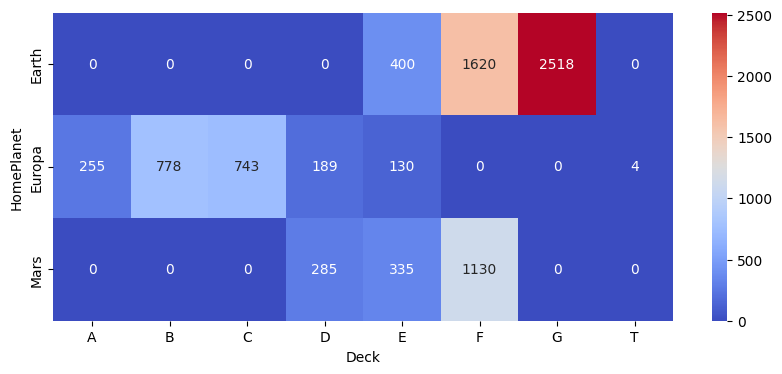

In [190]:
Deck_HP = df.groupby(['Deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(Deck_HP.T, annot=True, fmt='g', cmap='coolwarm')

Passengers of deck A,B,C,T are from Europa.
Passengers of deck G are from Earth.

In [191]:
df.loc[((df['Deck'].isin(['A', 'B', 'C', 'T'])) & (df['HomePlanet'].isna())), 'HomePlanet'] = 'Europa'
df.loc[((df['Deck']=='G') & (df['HomePlanet'].isna())), 'HomePlanet'] = 'Earth'

In [192]:
SHP_gb=df.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
SHP_gb

HomePlanet,Earth,Europa,Mars
Surname,,,
Acobson,4.0,0.0,0.0
Acobsond,3.0,0.0,0.0
Adavisons,9.0,0.0,0.0
Adkinson,3.0,0.0,0.0
Admingried,0.0,4.0,0.0
...,...,...,...
Wynneyerson,2.0,0.0,0.0
Yanton,7.0,0.0,0.0
Yatters,4.0,0.0,0.0


In [193]:
SHP_gb.index

Index(['Acobson', 'Acobsond', 'Adavisons', 'Adkinson', 'Admingried',
       'Ageurante', 'Aginge', 'Ailled', 'Aillyber', 'Aiming',
       ...
       'Wooterston', 'Workmans', 'Workmanson', 'Wrempeedly', 'Wriggins',
       'Wynneyerson', 'Yanton', 'Yatters', 'Yorkland', 'Youngrayes'],
      dtype='object', name='Surname', length=2213)

People having same surname are from same HomePlanet

In [194]:
HP_nan = df[df['HomePlanet'].isna()]
SHP_index = HP_nan[HP_nan['Surname'].isin(SHP_gb.index)].index
for idx in SHP_index:
    surname = df.loc[idx, 'Surname']
    if surname in SHP_gb.index:
        df.loc[idx, 'HomePlanet'] = SHP_gb.idxmax(axis=1)[surname]

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   HomePlanet        8685 non-null   object  
 1   CryoSleep         8476 non-null   object  
 2   Destination       8511 non-null   object  
 3   Age               8693 non-null   float64 
 4   VIP               8693 non-null   bool    
 5   RoomService       8693 non-null   int64   
 6   FoodCourt         8693 non-null   int64   
 7   ShoppingMall      8693 non-null   int64   
 8   Spa               8693 non-null   int64   
 9   VRDeck            8693 non-null   int64   
 10  Name              8493 non-null   object  
 11  Transported       8693 non-null   bool    
 12  Group             8693 non-null   object  
 13  passenger_number  8693 non-null   object  
 14  Deck              8494 non-null   object  
 15  Cabin_num         8494 non-null   object  
 16  Side              84

In [196]:
df[df['HomePlanet'].isna()][['HomePlanet','Destination']]

,HomePlanet,Destination
PassengerId,,
0242_01,NaN,TRAPPIST-1e
2443_01,NaN,TRAPPIST-1e
2817_01,NaN,TRAPPIST-1e
3331_01,NaN,TRAPPIST-1e
4840_01,NaN,TRAPPIST-1e
5603_01,NaN,TRAPPIST-1e
5989_01,NaN,TRAPPIST-1e
6108_01,NaN,TRAPPIST-1e


<Axes: xlabel='HomePlanet', ylabel='Destination'>

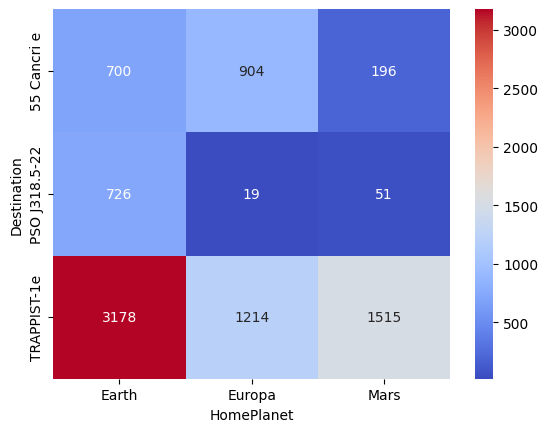

In [197]:
sample_df = df.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)
sns.heatmap(sample_df.T, annot=True, fmt='g', cmap='coolwarm')

No one from Deck = D is from Earth and most people with destination = TRAPPIST-1e are from Earth

In [198]:
df.loc[(df['HomePlanet'].isna()) & (df['Deck'] != 'D'), 'HomePlanet'] = 'Earth'
df.loc[(df['HomePlanet'].isna()) & (df['Deck'] == 'D'), 'HomePlanet'] = np.random.choice(['Europa', 'Mars'], size=df[(df['HomePlanet'].isna()) & (df['Deck'] == 'D')].shape[0])

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   HomePlanet        8693 non-null   object  
 1   CryoSleep         8476 non-null   object  
 2   Destination       8511 non-null   object  
 3   Age               8693 non-null   float64 
 4   VIP               8693 non-null   bool    
 5   RoomService       8693 non-null   int64   
 6   FoodCourt         8693 non-null   int64   
 7   ShoppingMall      8693 non-null   int64   
 8   Spa               8693 non-null   int64   
 9   VRDeck            8693 non-null   int64   
 10  Name              8493 non-null   object  
 11  Transported       8693 non-null   bool    
 12  Group             8693 non-null   object  
 13  passenger_number  8693 non-null   object  
 14  Deck              8494 non-null   object  
 15  Cabin_num         8494 non-null   object  
 16  Side              84

Text(0.5, 1.0, 'Distribution of Home Planet after Cleansing')

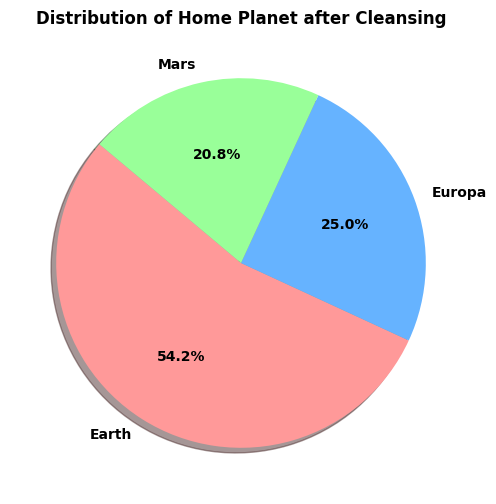

In [200]:
data = df['HomePlanet'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(12,6))
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140, colors = colors, shadow=True, textprops={'fontweight': 'bold'})
plt.title('Distribution of Home Planet after Cleansing', fontweight = 'bold')

### Old Method

**Data Structure for Stacked Bars**
In a stacked bar chart, you need a DataFrame where:
- The index represents the categories for the bars (e.g., HomePlanet).
- The columns represent the different segments of the bars (e.g., Transported status).
- The values in the DataFrame represent the heights of these segments.

In [112]:
df_homeplanet = df.copy().drop(['Transported','Name','Surname','VIP'] + spending_cols, axis=1)
df_homeplanet['AgeCategory'] = df_homeplanet['AgeCategory'].astype('object')

In [113]:
df_homeplanet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HomePlanet        8492 non-null   object 
 1   CryoSleep         8476 non-null   object 
 2   Destination       8511 non-null   object 
 3   Age               8693 non-null   float64
 4   Group             8693 non-null   object 
 5   passenger_number  8693 non-null   object 
 6   Deck              8494 non-null   object 
 7   Cabin_num         8494 non-null   object 
 8   Side              8494 non-null   object 
 9   Spending          8693 non-null   int64  
 10  AgeCategory       8693 non-null   object 
 11  GroupSize         8693 non-null   int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 1.1+ MB


In [73]:
df_homeplanet.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'Group',
       'passenger_number', 'Deck', 'Cabin_num', 'Side', 'Spending',
       'AgeCategory', 'GroupSize'],
      dtype='object')

In [114]:
# Select features and target for machine learning model

features = df_homeplanet[df_homeplanet['HomePlanet'].notna()].drop(columns=['HomePlanet'])  # Get features data without HomePlanet

object_features = ['CryoSleep', 'Deck', 'Side','Destination','AgeCategory']
features[object_features] = features[object_features].fillna('Missing')
features['CryoSleep'] = features['CryoSleep'].astype(str)

num_cols = ['Age', 'Spending', 'GroupSize','passenger_number','Group','Cabin_num']
for i in num_cols:
    df_homeplanet[i] = df_homeplanet[i].astype('float64')
impute_mean = SimpleImputer(strategy='mean') # Temporary filling mean values for NA cells
features[num_cols] = impute_mean.fit_transform(features[num_cols]) # Filling Missing for NA cells

target = pd.DataFrame(df_homeplanet[df_homeplanet['HomePlanet'].notna()].HomePlanet) # Get HomePlanet which is NA only
test_homeplanet_df = df_homeplanet[df_homeplanet['HomePlanet'].isna()]

In [115]:
# Label Encoding for target
label_encoder = LabelEncoder()
encoded_target = label_encoder.fit_transform(target)
encoded_target

/Users/ezishr/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 0, 1, ..., 0, 1, 1])

In [116]:
# One Hot Encoding
def one_hot_encoding_obj_features(df, object_columns, numerical_cols):
    one_hot_encoder = OneHotEncoder(sparse=False)
    encoded_features = one_hot_encoder.fit_transform(df[object_columns])
    encoded_features_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(object_columns))
    encoded_features_df.set_index(df.index, inplace=True)

    final_features = pd.concat([encoded_features_df, df[numerical_cols]], axis=1)
    return final_features

features = one_hot_encoding_obj_features(features, object_features, num_cols)
sample = test_homeplanet_df.copy().drop(columns='HomePlanet')
sample[object_features] = sample[object_features].fillna('Missing')
sample[num_cols] = impute_mean.fit_transform(sample[num_cols])
sample['CryoSleep'] = sample['CryoSleep'].astype(str)
X_test = one_hot_encoding_obj_features(sample,object_features,num_cols)

In [117]:
# Split features and target into different set
X_train, X_val, y_train, y_val = train_test_split(features, encoded_target, train_size=0.8, test_size=0.2, random_state=1)

y_test = pd.DataFrame(test_homeplanet_df['HomePlanet'])
y_test

,HomePlanet
PassengerId,
0064_02,NaN
0119_01,NaN
0210_01,NaN
0242_01,NaN
0251_01,NaN
...,...
9084_01,NaN
9194_01,NaN
9248_01,NaN


In [118]:
# Build Decision Tree Classifier Model
decision_tree = DecisionTreeClassifier(random_state=1)
decision_tree.fit(X_train, y_train)

# Predictions based on validation set
y_pred = decision_tree.predict(X_val)
print('Accuracy score based on validation set:',accuracy_score(y_val, y_pred))

# Cross-validation
print('Cross validation score:',cross_val_score(decision_tree, X_train, y_train, cv = 5, scoring = 'accuracy'))

Accuracy score based on validation set: 0.9181871689228959
Cross validation score: [0.92494481 0.91317145 0.92494481 0.91752577 0.91458027]


In [119]:
# Build Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100,random_state=1)
random_forest.fit(X_train, y_train)
y_rd_pred = random_forest.predict(X_val)
print('Accuracy score based on validation set:',accuracy_score(y_val, y_rd_pred))
print('Cross validation score:',cross_val_score(random_forest, X_train, y_train, cv = 5, scoring='accuracy'))

Accuracy score based on validation set: 0.909358446144791
Cross validation score: [0.9205298  0.89477557 0.90875644 0.90353461 0.90942563]


In [120]:
# Predictions for actual NA by Decision Tree
y_filling = decision_tree.predict(X_test)
y_test['HomePlanet'] = y_filling

# Decoding predictions
decoded_predictions = pd.DataFrame(label_encoder.inverse_transform(y_test)).set_index(y_test.index)

/Users/ezishr/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [121]:
decoded_predictions

,0
PassengerId,
0064_02,Mars
0119_01,Europa
0210_01,Europa
0242_01,Earth
0251_01,Europa
...,...
9084_01,Mars
9194_01,Europa
9248_01,Earth


In [122]:
df_homeplanet.loc[df_homeplanet['HomePlanet'].isna(), 'HomePlanet'] = decoded_predictions[0]
df_homeplanet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HomePlanet        8693 non-null   object 
 1   CryoSleep         8476 non-null   object 
 2   Destination       8511 non-null   object 
 3   Age               8693 non-null   float64
 4   Group             8693 non-null   float64
 5   passenger_number  8693 non-null   float64
 6   Deck              8494 non-null   object 
 7   Cabin_num         8494 non-null   float64
 8   Side              8494 non-null   object 
 9   Spending          8693 non-null   float64
 10  AgeCategory       8693 non-null   object 
 11  GroupSize         8693 non-null   float64
dtypes: float64(6), object(6)
memory usage: 1.1+ MB


Text(0.5, 1.0, 'Distribution of Home Planet after Cleansing')

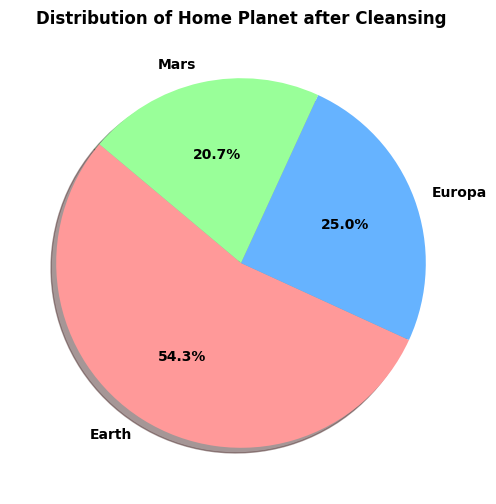

In [124]:
# See distribution of Home Planet after cleansing
data = df_homeplanet['HomePlanet'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(12,6))
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140, colors = colors, shadow=True, textprops={'fontweight': 'bold'})
plt.title('Distribution of Home Planet after Cleansing', fontweight = 'bold')
# homeplanet_counts: The data for the pie chart.
# labels=homeplanet_counts.index: The labels for each slice of the pie chart.
# autopct='%1.1f%%': Displays the percentage of each slice.
# startangle=140: Rotates the start angle of the pie chart for better visualization.

## Cleansing Destination

### Scaling Age Col

In [201]:
df['Destination'].isna().sum()

182

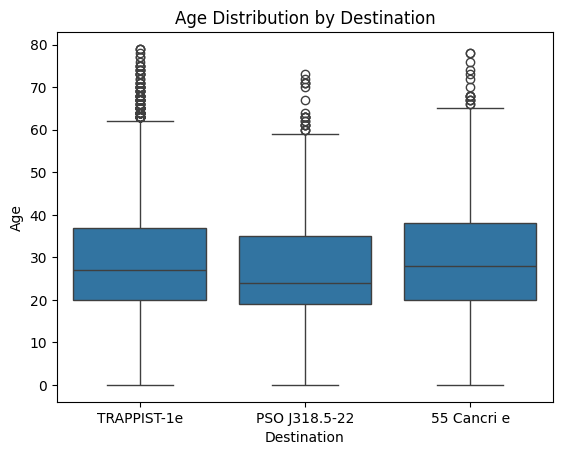

In [202]:
sns.boxplot(data=df, x='Destination', y='Age')
plt.title('Age Distribution by Destination')
plt.show()

Above graph shows that distributions in these destinations are similar in terms of statistics.

Text(0.5, 1.0, 'Distribution of HomePlanet by Destination')

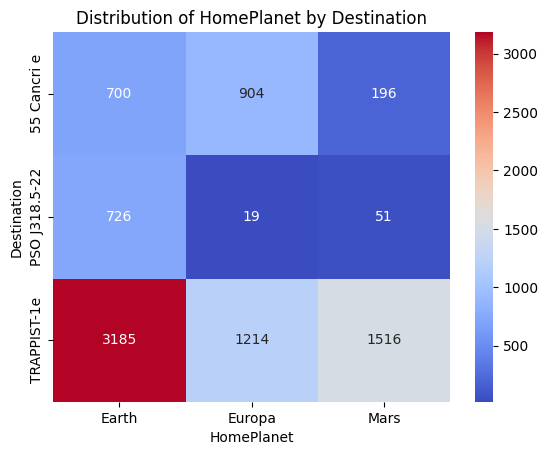

In [203]:
pivot_data = df.pivot_table(index='Destination',columns='HomePlanet',aggfunc='size', fill_value=0)
sns.heatmap(data=pivot_data, cmap='coolwarm', fmt='g', annot = True)
plt.title('Distribution of HomePlanet by Destination')

We can see that most people from every Home Planet go mostly to TRAPPIST-1e and least likely go to PSO J318.5-22

Text(0.5, 1.0, 'Distribution of Age Category by Destination')

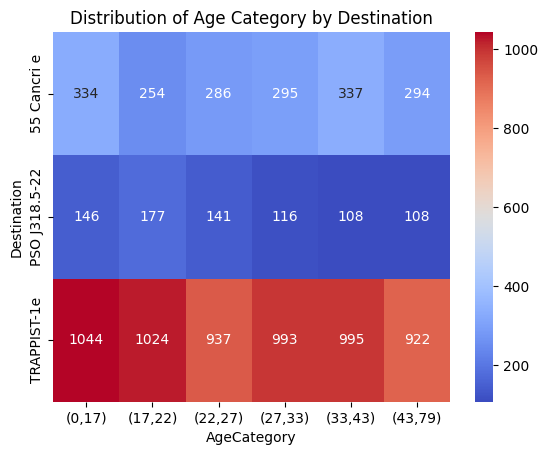

In [204]:
pivot_data = df.pivot_table(index='Destination',columns='AgeCategory',aggfunc='size', fill_value=0)
sns.heatmap(data=pivot_data, cmap='coolwarm', fmt='g', annot = True)
plt.title('Distribution of Age Category by Destination')

Text(0.5, 1.0, 'Distribution of CryoSleep Status by Destination')

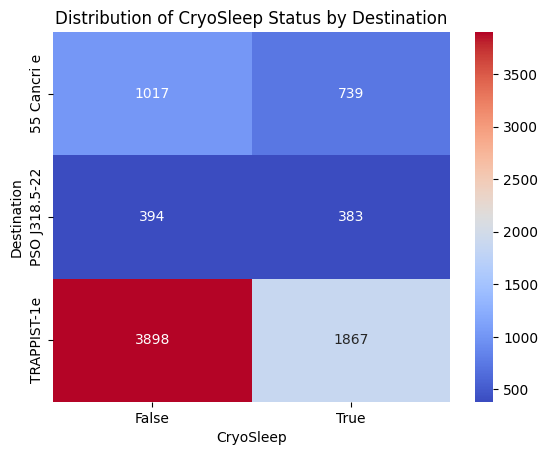

In [205]:
pivot_data = df.pivot_table(index='Destination',columns='CryoSleep',aggfunc='size', fill_value=0)
sns.heatmap(data=pivot_data, cmap='coolwarm', fmt='g', annot = True)
plt.title('Distribution of CryoSleep Status by Destination')

In [206]:
df_destination = df.copy().drop(['Name','Surname'],axis=1)

In [207]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# The error message indicates that the StandardScaler expects a 2D array as input, but it's receiving a 1D array instead. When you select a single column from a DataFrame (like df_destination['Spending']), it returns a Series, which is a 1D array.

non_zero_spending = df_destination[df_destination['Spending']!=0]
scaler_spending = scaler.fit_transform(non_zero_spending[['Spending']]).round(3)
# scaler_spending_df = pd.DataFrame(scaler_spending, columns=['Spending_Scale'])

df_destination.loc[non_zero_spending.index,'Spending_Scale'] = scaler_spending
df_destination['Spending_Scale'].fillna(0,inplace=True)

Text(0.5, 1.0, 'Distribution of Spending')

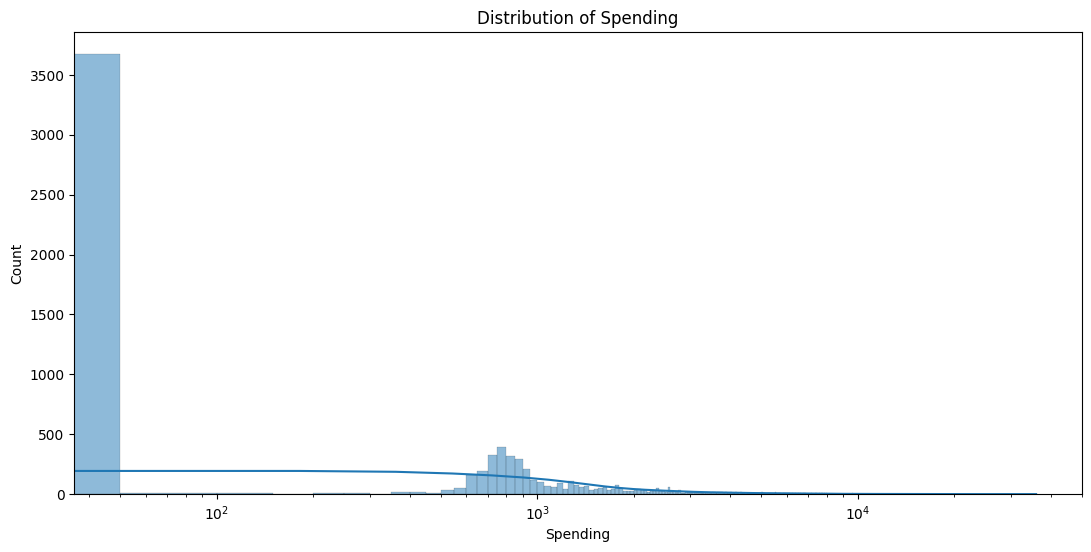

In [208]:
plt.figure(figsize=(13,6))
sns.histplot(data=df_destination['Spending'], kde=True, binwidth=50)
plt.xscale('log')
plt.title("Distribution of Spending")

Since there are over 3500 entries with 0 spending (around a half of total passengers), we will scale only non-zero values.

In [209]:
df_destination['Spending_Scale'].unique()

array([ 0.   , -0.528,  2.386, ...,  2.317,  1.909,  1.828])

In [210]:
df_destination[['Spending','Spending_Scale']].head(10)

,Spending,Spending_Scale
PassengerId,,
0001_01,0,0.000
0002_01,736,-0.528
0003_01,10383,2.386
0003_02,5176,0.813
0004_01,1091,-0.421
0005_01,774,-0.517
0006_01,1584,-0.272
0006_02,0,0.000
0007_01,1018,-0.443


In [211]:
df_destination.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Group',
       'passenger_number', 'Deck', 'Cabin_num', 'Side', 'Spending',
       'AgeCategory', 'GroupSize', 'Spending_Scale'],
      dtype='object')

### Data Modeling

In [225]:
selected_features = ['HomePlanet', 'CryoSleep', 'Deck', 'Cabin_num', 'Side', 'AgeCategory', 'GroupSize', 'Spending_Scale']
X_train, X_val, y_train, y_val, y_test = preprocess_data(df_destination, 'Destination', 0.8, 0.2, selected_features)

ValueError: Found input variables with inconsistent numbers of samples: [8693, 8538]

In [64]:
decision_tree_classifier(X_train, X_val, y_train, y_val, y_test,5)

Accuracy score based on validation set (DESICION TREE): 0.6494421608925426
Cross validation score: [0.66226138 0.64537445 0.6732746  0.63776635 0.66568699]
Important features:                Features  Importance
1     HomePlanet_Europa       0.061
0      HomePlanet_Earth       0.019
6121             Deck_E       0.005
6122             Deck_F       0.002
6120             Deck_D       0.002
1654         Group_2512       0.001
4732         Group_7134       0.001
1684         Group_2552       0.001
1679         Group_2547       0.001
1677         Group_2545       0.001


In [63]:
random_forest_classifier(X_train, X_val, y_train, y_val, y_test,5)

Accuracy score based on validation set (RANDOM FOREST TREE): 0.6694069289489136
Cross validation score: [0.67400881 0.66079295 0.68135095 0.65686995 0.67597355]
Important features:                Features  Importance
1     HomePlanet_Europa       0.021
2       HomePlanet_Mars       0.013
0      HomePlanet_Earth       0.012
6122             Deck_F       0.007
6123             Deck_G       0.006
6119             Deck_C       0.006
6118             Deck_B       0.005
6121             Deck_E       0.004
206          Group_0313       0.002
6117             Deck_A       0.002


In [74]:
logistic_regression_classifier(X_train, X_val, y_train, y_val, y_test,5)

Accuracy score based on validation set (LOGISTIC REGRESSION): 0.6923076923076923
Cross-validation score: [0.68942731 0.67914831 0.69530103 0.68038207 0.68993387]
         Feature  Coefficient  Absolute Coefficient
5360  Group_8119     1.226722              1.226722
2299  Group_3476     1.149420              1.149420
2800  Group_4223     1.116360              1.116360
2354  Group_3562     1.107530              1.107530
5151  Group_7803     1.086110              1.086110
1807  Group_2732     1.085082              1.085082
1684  Group_2552     1.085082              1.085082
5682  Group_8615     1.078440              1.078440
1405  Group_2137     1.075239              1.075239
528   Group_0794     1.074990              1.074990


In [68]:
xgb_classifier(X_train, X_val, y_train, y_val, y_test,5)

Accuracy score based on validation set (XGB): 0.6940692894891368
Cross-validation score: [0.68722467 0.68649046 0.69089574 0.69140338 0.69066863]
Important features:                Features  Importance
1     HomePlanet_Europa       0.118
2       HomePlanet_Mars       0.116
0      HomePlanet_Earth       0.107
6123             Deck_G       0.011
5360         Group_8119       0.010
206          Group_0313       0.009
2299         Group_3476       0.008
1473         Group_2234       0.008
432          Group_0642       0.007
482          Group_0714       0.007


<Axes: xlabel='HomePlanet', ylabel='count'>

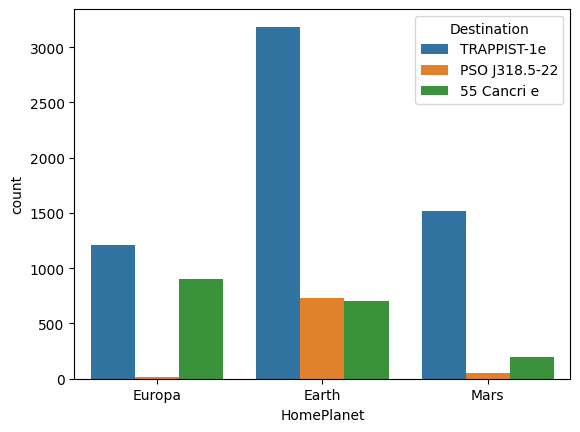

In [72]:
sns.countplot(data=df_destination, x='HomePlanet', hue='Destination')

(<Figure size 640x480 with 3 Axes>,
 {('Europa', 'TRAPPIST-1e'): (0.0,
   0.0,
   0.24860082060373817,
   0.5643239423961919),
  ('Europa', 'PSO J318.5-22'): (0.0,
   0.5676352006743376,
   0.24860082060373817,
   0.008832088060566389),
  ('Europa', '55 Cancri e'): (0.0,
   0.5797785470130496,
   0.24860082060373817,
   0.4202214529869502),
  ('Earth', 'TRAPPIST-1e'): (0.2535513156532431,
   0.0,
   0.5364054205914071,
   0.6861651018798983),
  ('Earth', 'PSO J318.5-22'): (0.2535513156532431,
   0.689476360158044,
   0.5364054205914071,
   0.15640686466712914),
  ('Earth', '55 Cancri e'): (0.2535513156532431,
   0.8491944831033189,
   0.5364054205914071,
   0.15080551689668098),
  ('Mars', 'TRAPPIST-1e'): (0.7949072312941552,
   0.0,
   0.20509276870584486,
   0.8542032132164844),
  ('Mars', 'PSO J318.5-22'): (0.7949072312941552,
   0.85751447149463,
   0.20509276870584486,
   0.02873638777971028),
  ('Mars', '55 Cancri e'): (0.7949072312941552,
   0.8895621175524862,
   0.205092768705

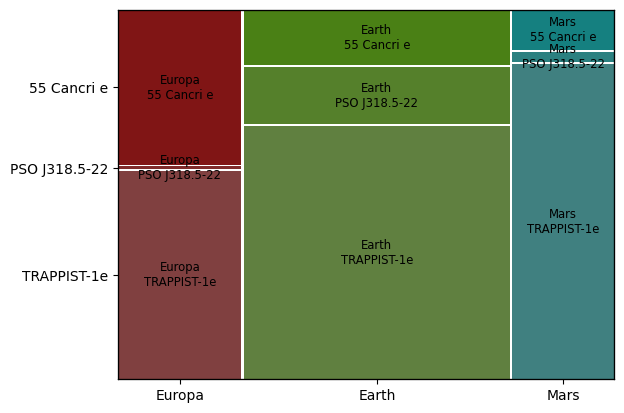

In [77]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df_destination, ['HomePlanet','Destination'])

### Clean based on Same Group

In [212]:
sample = pd.DataFrame(df_destination.groupby('Group')['Destination'].nunique())
same_dest_group = sample[sample['Destination'] == 1]

In [213]:
na_dest_same_group = df_destination[df_destination.Group.isin(same_dest_group.index)]
na_dest_same_group = na_dest_same_group[na_dest_same_group['Destination'].isna()]
na_dest_same_group = na_dest_same_group[['Group','Destination']].set_index('Group')

In [214]:
notNA_dest = df_destination[df_destination.Group.isin(same_dest_group.index.tolist())]
notNA_dest = notNA_dest[['Group','Destination']]
unique_groups = notNA_dest.drop_duplicates(subset='Group').set_index('Group')

In [215]:
na_dest_same_group['Destination'].update(unique_groups['Destination'])
na_dest_same_group.reset_index(inplace=True)

In [216]:
df_destination = df_destination.merge(na_dest_same_group, on='Group', how='left', suffixes=('', '_new'))
df_destination['Destination'].fillna(df_destination['Destination_new'], inplace=True)
df_destination.drop(columns=['Destination_new'], inplace=True)
df_destination['Destination'].isna().sum()

155

### Clean the others

In [218]:
df_destination.isna().sum()

HomePlanet            0
CryoSleep           217
Destination         155
Age                   0
VIP                   0
RoomService           0
FoodCourt             0
ShoppingMall          0
Spa                   0
VRDeck                0
Transported           0
Group                 0
passenger_number      0
Deck                199
Cabin_num           199
Side                199
Spending              0
AgeCategory           0
GroupSize             0
Spending_Scale        0
dtype: int64